# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

<div class="span5 alert alert-info">
### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet


#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
</div>
****

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt

import seaborn as sns

import numpy as np

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

In [2]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [3]:
# number of callbacks for black-sounding names
sum(data[data.race=='b'].call)

157.0

In [4]:
data.head()

,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
1,b,1,3,3,6,0,1,1,0,316,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
2,b,1,4,1,6,0,0,0,0,19,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
3,b,1,3,4,6,0,1,0,1,313,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
4,b,1,3,3,22,0,0,0,0,313,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Nonprofit


In [5]:
len(data.id)

4870

In [6]:
data.columns

Index(['id', 'ad', 'education', 'ofjobs', 'yearsexp', 'honors', 'volunteer',
       'military', 'empholes', 'occupspecific', 'occupbroad', 'workinschool',
       'email', 'computerskills', 'specialskills', 'firstname', 'sex', 'race',
       'h', 'l', 'call', 'city', 'kind', 'adid', 'fracblack', 'fracwhite',
       'lmedhhinc', 'fracdropout', 'fraccolp', 'linc', 'col', 'expminreq',
       'schoolreq', 'eoe', 'parent_sales', 'parent_emp', 'branch_sales',
       'branch_emp', 'fed', 'fracblack_empzip', 'fracwhite_empzip',
       'lmedhhinc_empzip', 'fracdropout_empzip', 'fraccolp_empzip',
       'linc_empzip', 'manager', 'supervisor', 'secretary', 'offsupport',
       'salesrep', 'retailsales', 'req', 'expreq', 'comreq', 'educreq',
       'compreq', 'orgreq', 'manuf', 'transcom', 'bankreal', 'trade',
       'busservice', 'othservice', 'missind', 'ownership'],
      dtype='object')

# Part 1：whether race has a significant impact on the rate of callbacks for resumes.

In [7]:
data_new = data.loc[:,["race","call"]]

In [8]:
data_new.head(5)

,race,call
0,w,0.0
1,w,0.0
2,b,0.0
3,b,0.0
4,w,0.0


In [9]:
counts = data_new.groupby("race").call.value_counts(normalize = bool)
counts

race  call
b     0.0     0.935524
      1.0     0.064476
w     0.0     0.903491
      1.0     0.096509
Name: call, dtype: float64

In [10]:
group_w = data_new[data_new.race=="w"].call
group_b = data_new[data_new.race=="b"].call
group_w.mean() - group_b.mean()

0.03203285485506058

1) Performing two-sample t-test on two groups, assuming they have the same population variance. CLT applies here because the sample size is big enough.
Null hypothesis: two independent groups have same mean
Alternative hypothesis: two groups have different mean

In [11]:
# using two sample t-test
stats.ttest_ind_from_stats(group_w.mean(), group_w.std(), len(group_w), group_b.mean(), group_b.std(), len(group_b), equal_var=True)

Ttest_indResult(statistic=4.114738324427746, pvalue=3.9402397721424879e-05)

Conclusion 1: p-value < .05, reject null hypothesis. two-sample t-test suggest that two group have significant different means.

2) Test difference in means by permutation: 

In [12]:
# structure of hypothesis test 
class HypothesisTest(object):
    """Represents a hypothesis test."""

    def __init__(self, data):
        """Initializes.

        data: data in whatever form is relevant
        """
        self.data = data
        self.MakeModel()
        self.actual = self.TestStatistic(data)
        self.test_stats = None

    def PValue(self, iters=1000):
        """Computes the distribution of the test statistic and p-value.

        iters: number of iterations

        returns: float p-value
        """
        self.test_stats = np.array([self.TestStatistic(self.RunModel()) 
                                       for _ in range(iters)])

        count = sum(self.test_stats >= self.actual)
        return count / iters

    def MaxTestStat(self):
        """Returns the largest test statistic seen during simulations.
        """
        return max(self.test_stats)

    def PlotHist(self, label=None):
        """Draws a Cdf with vertical lines at the observed test stat.
        """
        ys, xs, patches = plt.hist(ht.test_stats, color = 'grey' )
        plt.vlines(self.actual, 0, max(ys), linewidth=3, color='red')
        plt.xlabel('test statistic')
        plt.ylabel('count')

    def TestStatistic(self, data):
        """Computes the test statistic.

        data: data in whatever form is relevant        
        """
        raise UnimplementedMethodException()

    def MakeModel(self):
        """Build a model of the null hypothesis.
        """
        pass

    def RunModel(self):
        """Run the model of the null hypothesis.

        returns: simulated data
        """
        raise UnimplementedMethodException()


In [13]:
class DiffMeansPermute(HypothesisTest):
    """Tests a difference in means by permutation."""

    def TestStatistic(self, data):
        """Computes the test statistic.

        data: data in whatever form is relevant        
        """
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat

    def MakeModel(self):
        """Build a model of the null hypothesis.
        """
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        """Run the model of the null hypothesis.

        returns: simulated data
        """
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

In [14]:
# call functions on two different groups
data = (group_w, group_b)
ht = DiffMeansPermute(data)
p_value = ht.PValue(iters=1000)
print('\nmeans white black call difference')
print('p-value =', p_value)
print('actual =', ht.actual)
print('ts max =', ht.MaxTestStat())


means white black call difference
p-value = 0.0
actual = 0.03203285485506058
ts max = 0.0262834


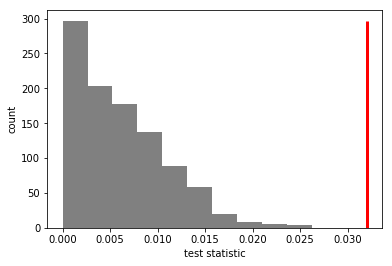

In [15]:
# plot of test statistics distribution v.s. actual statistics 
ht.PlotHist()
plt.show()

Conclusing 2: Hypothesis testing by running permutations yield the same result. p-value < .001 reject null hypothesis that two group have same mean.

3） Compute the effect size, plot confidence interval for mean difference

In [16]:
# compute the effect size Cohen_d
def text(x, y, s):
    """Plot a string at a given location in axis coordinates.
    
    x: coordinate
    y: coordinate
    s: string
    """
    ax = plt.gca()
    plt.text(x, y, s,
                horizontalalignment='left',
                verticalalignment='top',
                transform=ax.transAxes)
    
class Resampler(object):
    """Represents a framework for computing sampling distributions."""
    
    def __init__(self, sample, xlim=None):
        """Stores the actual sample."""
        self.sample = sample
        self.n = len(sample)
        self.xlim = xlim
        
    def resample(self):
        """Generates a new sample by choosing from the original
        sample with replacement.
        """
        new_sample = np.random.choice(self.sample, self.n, replace=True)
        return new_sample
    
    def sample_stat(self, sample):
        """Computes a sample statistic using the original sample or a
        simulated sample.
        """
        return sample.mean()
    
    def compute_sampling_distribution(self, iters=1000):
        """Simulates many experiments and collects the resulting sample
        statistics.
        """
        stats = [self.sample_stat(self.resample()) for i in range(iters)]
        return np.array(stats)
    
    def plot_sampling_distribution(self):
        """Plots the sampling distribution."""
        sample_stats = self.compute_sampling_distribution()
        se = sample_stats.std()
        ci = np.percentile(sample_stats, [5, 95])
    
        plt.hist(sample_stats)
        plt.xlabel('sample statistic')
        plt.xlim(self.xlim)
        text(0.03, 0.95, 'CI [%0.2f %0.2f]' % tuple(ci))
        text(0.03, 0.85, 'SE %0.2f' % se)
        plt.show()

def CohenEffectSize(group1, group2):
    """Compute Cohen's d.

    group1: Series or NumPy array
    group2: Series or NumPy array

    returns: float
    """
    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    d = diff / np.sqrt(pooled_var)
    return d

In [17]:
# make sample from original samples
class CohenResampler(Resampler):
    def __init__(self, group1, group2, xlim=None):
        self.group1 = group1
        self.group2 = group2
        self.xlim = xlim
    def resample(self):
        n, m = len(self.group1), len(self.group2)
        group1 = np.random.choice(self.group1, n, replace=True)
        group2 = np.random.choice(self.group2, m, replace=True)
        return group1, group2
    def sample_stat(self, groups):
        group1, group2 = groups
        return group1.mean()-group2.mean()

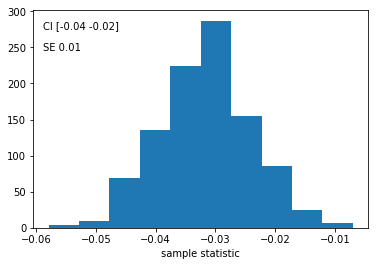

In [18]:
# plot the distribution of mean difference
resampler = CohenResampler(group_b, group_w)
resampler.plot_sampling_distribution()

The plot shows that 90% confidence interval for difference in means is [-.04,-.02]. Only considering race as a factor, the black group call back rate is slightly lower than white candidates. Margin of error is .01.

4) Calculate effect size: cohen_d and plot the distribution with overlap & superiority rate

In [19]:
def eval_pdf(rv, num=4):
    mean, std = rv.mean(), rv.std()
    xs = np.linspace(mean - num*std, mean + num*std, 100)
    ys = rv.pdf(xs)
    return xs, ys

def overlap_superiority(control, treatment, n=1000):
    """Estimates overlap and superiority based on a sample.
    
    control: scipy.stats rv object
    treatment: scipy.stats rv object
    n: sample size
    """
    control_sample = control.rvs(n)
    treatment_sample = treatment.rvs(n)
    thresh = (control.mean() + treatment.mean()) / 2
    
    control_above = sum(control_sample > thresh)
    treatment_below = sum(treatment_sample < thresh)
    overlap = (control_above + treatment_below) / n
    
    superiority = (treatment_sample > control_sample).mean()
    return overlap, superiority

def plot_pdfs(cohen_d=2):
    """Plot PDFs for distributions that differ by some number of stds.
    
    cohen_d: number of standard deviations between the means
    """
    control = stats.norm(0, 1)
    treatment = stats.norm(cohen_d, 1)
    xs, ys = eval_pdf(control)
    plt.fill_between(xs, ys, label='control', color='green', alpha=0.7)

    xs, ys = eval_pdf(treatment)
    plt.fill_between(xs, ys, label='treatment', color='yellow', alpha=0.7)
    
    o, s = overlap_superiority(control, treatment)
    plt.text(0, 0.05, 'overlap ' + str(o))
    plt.text(0, 0.15, 'superiority ' + str(s))
    plt.show()
    #print('overlap', o)
    #print('superiority', s)

In [20]:
CohenEffectSize(group_w, group_b)

0.11792550421490766

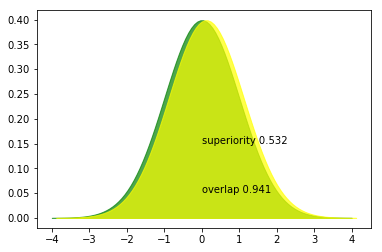

In [21]:
plot_pdfs(CohenEffectSize(group_w, group_b))

Conclusion 4: Overlape rate is .983, the probability that white group has higher call back rate is 51.8%

# Part 2 :Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

The anaysis above indicate that call back rate for different race (b/w) is different, with white group slightly higher than black group; however, it does not indicate that race is the most important factor in callback success. Because in the analysis above, we did not consider other factors such as education, years of experience and etc. To make the anaysis more accurate, we should control other variables unchange while comparing the difference in group mean. 